In [2]:
# load the environment variables and the required libraries
import os
import uuid
from dotenv import load_dotenv
import requests
import torch
import onnxruntime
from PIL import Image
from transformers import AutoProcessor, SiglipModel, AutoTokenizer
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct

load_dotenv()

qdrant_cloud_key = os.getenv("QDRANT_CLOUD_KEY")
qdrant_local_key = os.getenv("QDRANT_LOCAL_KEY")
hf_key = os.getenv("HF_KEY")

In [3]:
def to_numpy(tensor):
    return (
        tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    )

In [4]:
# load the model and the tokenizer
ort_vision = onnxruntime.InferenceSession(
    "siglip_vision.onnx",
    providers=[
        "CUDAExecutionProvider",
        "CPUExecutionProvider",
    ],
)

ort_text = onnxruntime.InferenceSession(
    "siglip_text.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)
processor = AutoProcessor.from_pretrained("nielsr/siglip-base-patch16-224")
tokenizer = AutoTokenizer.from_pretrained("nielsr/siglip-base-patch16-224")

/var/lib/storage/miniconda3/envs/hcmai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# get the image from the url
headers = {"Authorization": f"Bearer {hf_key}"}
API_URL = "https://datasets-server.huggingface.co/rows?dataset=huggan/wikiart&config=default&split=train&offset=1&length=100"


def query():
    response = requests.get(API_URL, headers=headers)
    return response.json()


data = query()
len(data["rows"])  # 100 images

100

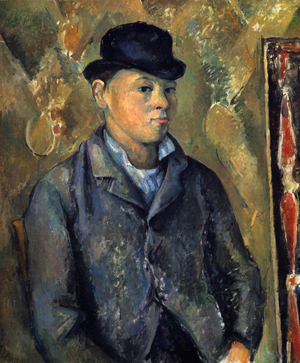

In [6]:
# display the image
url = data["rows"][1]["row"]["image"]["src"]
image = Image.open(requests.get(url, stream=True).raw)
# images are way too large that make this notebook too large as well
# downscale
width = 300
ratio = width / float(image.size[0])
height = int((float(image.size[1]) * float(ratio)))
img = image.resize((width, height), Image.Resampling.LANCZOS)
display(img)

In [7]:
client = QdrantClient(url="http://localhost:6333", api_key=qdrant_local_key)

# create a collection
client.create_collection(
    collection_name="onnx_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

/var/lib/storage/miniconda3/envs/hcmai/lib/python3.10/site-packages/qdrant_client/qdrant_remote.py:130: UserWarning: Api key is used with an insecure connection.
  warnings.warn("Api key is used with an insecure connection.")


True

In [14]:
def add_vector(client, embedding, row_idx):
    """
    Add the vector to the collection
    """
    # default datatype for vectors is float32
    id = str(uuid.uuid4())
    operation_info = client.upsert(
        collection_name="onnx_collection",
        wait=True,
        points=[
            PointStruct(id=id, vector=embedding, payload={"row_idx": row_idx}),
        ],
    )

    print(operation_info)


def embed_siglip(image):
    """
    Embed the image using the Siglip model
    """
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt")
        ort_inputs = {ort_vision.get_inputs()[0].name: to_numpy(tuple(inputs.values())[0])}
        image_features = ort_vision.run(None, ort_inputs)
        return image_features[1].squeeze()

In [ ]:
# embed the image and add it to the collection
for elem in data["rows"]:
    url = elem["row"]["image"]["src"]
    image = Image.open(requests.get(url, stream=True).raw)
    feature = embed_siglip(image)
    add_vector(client, feature, elem["row_idx"])

In [17]:
prompt = "a woman"

text_token = tokenizer([prompt], return_tensors="pt")
ort_inputs = {ort_text.get_inputs()[0].name: to_numpy(tuple(text_token.values())[0])}
text_features = ort_text.run(None, ort_inputs)
text_features = np.float32(text_features[1].squeeze())
results = client.query_points(
    collection_name="onnx_collection", query=text_features, limit=3
)

In [18]:
row_idxs = [results.points[i].payload["row_idx"] for i in range(3)]

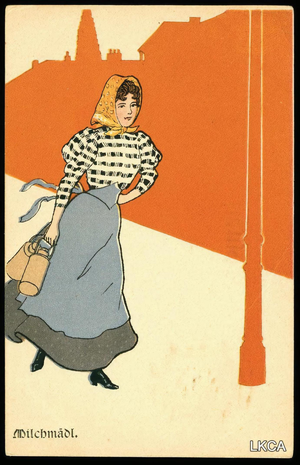

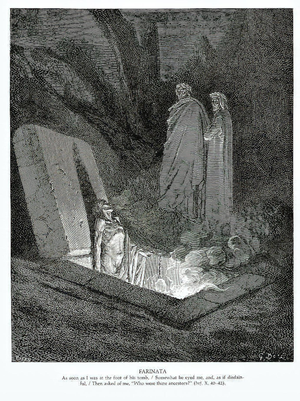

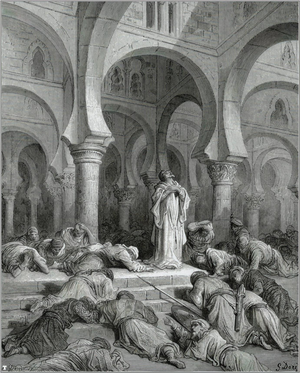

In [19]:
for elem in row_idxs:
    url = data["rows"][elem - 1]["row"]["image"]["src"]
    image = Image.open(requests.get(url, stream=True).raw)

    # downscale
    width = 300
    ratio = width / float(image.size[0])
    height = int((float(image.size[1]) * float(ratio)))
    img = image.resize((width, height), Image.Resampling.LANCZOS)
    display(img)